In [16]:
#!pip install backtrader
#!pip install yfinance
!pip install --upgrade pandas yfinance


In [13]:
import datetime  
import backtrader as bt
import pandas as pd
import datetime  # For datetime objects
import os.path  # To manage paths
import sys 
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import yfinance as yf


In [40]:
class TestStrategy(bt.Strategy):
    
    params = (
        ('threshold', 400),
        ('percent_of_portfolio', 0.10),
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
        

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose1 = self.datas[0].close
        self.dataclose2 = self.datas[1].close


        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.bar_executed = {}

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

                self.bar_executed[order.ref] = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Vérifier si les deux indices ont monté
        if self.dataclose1[0] > self.dataclose1[-1] and self.dataclose2[0] > self.dataclose2[-1]:
            # Acheter 2 unités de chaque indice
            self.order = self.buy(data=self.datas[0], size=2)
            self.order = self.buy(data=self.datas[1], size=2)
            self.bar_executed[len(self)] = 2  # Garder une trace du jour d'achat

        # Vérifier pour vendre après 5 jours
        for order_ref, order_bar in list(self.bar_executed.items()):
            if len(self) >= (order_bar + 5):
                self.sell(data=self.datas[0], size=2)
                self.sell(data=self.datas[1], size=2)
                del self.bar_executed[order_ref]

                

In [ ]:
if __name__ == '__main__':
    cerebro = bt.Cerebro()
    
    
    cerebro.addstrategy(TestStrategy)
    
    # Create a Data Feed
    data1 = bt.feeds.YahooFinanceCSVData(
        dataname='Bloomberg_Barclays_US_Government_Inflation-Linked_7_to_10_Years.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2000, 1, 1),
        # Do not pass values after this date
        todate=datetime.datetime(2023, 12, 31),
        reverse=False)
    
    data2=bt.feeds.YahooFinanceCSVData(
        dataname='snpValues.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2017, 1, 10),
        # Do not pass values after this date
        todate=datetime.datetime(2023, 12, 31),
        reverse=False)
    
    # Add the Data Feed to Cerebro
    cerebro.adddata(data1)
    cerebro.adddata(data2)

    cerebro.broker.setcash(1000000000.0)
    cerebro.broker.setcommission(commission=0.001)

    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.run()

    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    

Starting Portfolio Value: 1000000000.00
2017-01-13, BUY EXECUTED, Price: 2269.14, Cost: 4538.28, Comm 4.54
2017-01-13, BUY EXECUTED, Price: 2271.90, Cost: 4543.80, Comm 4.54
2017-01-13, SELL EXECUTED, Price: 2271.90, Cost: 4541.04, Comm 4.54
2017-01-13, SELL EXECUTED, Price: 2271.90, Cost: 4541.04, Comm 4.54
2017-01-13, OPERATION PROFIT, GROSS 5.52, NET -12.65
2017-01-20, BUY EXECUTED, Price: 296.28, Cost: 592.56, Comm 0.59
2017-01-20, BUY EXECUTED, Price: 296.28, Cost: 592.56, Comm 0.59
2017-01-20, SELL EXECUTED, Price: 296.28, Cost: 592.56, Comm 0.59
2017-01-20, SELL EXECUTED, Price: 296.28, Cost: 592.56, Comm 0.59
2017-01-20, OPERATION PROFIT, GROSS 0.00, NET -2.37
2017-01-27, SELL EXECUTED, Price: 296.89, Cost: -593.78, Comm 0.59
2017-01-27, SELL EXECUTED, Price: 2299.02, Cost: -4598.04, Comm 4.60
2017-01-27, SELL EXECUTED, Price: 296.89, Cost: -593.78, Comm 0.59
2017-01-27, SELL EXECUTED, Price: 2299.02, Cost: -4598.04, Comm 4.60
2017-01-27, SELL EXECUTED, Price: 2286.01, Cost: -4

2017-03-24, BUY EXECUTED, Price: 2356.54, Cost: -4715.02, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2356.54, Cost: -4713.08, Comm 4.71
2017-03-24, SELL EXECUTED, Price: 2

2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 0.60
2017-04-07, SELL EXECUTED, Price: 298.93, Cost: -597.86, Comm 

2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 2352.15, Cost: -4704.30, Comm 4.70
2017-04-07, SELL EXECUTED, Price: 

2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 2332.62, Cost: -4665.24, Comm 4.67
2017-04-14, SELL EXECUTED, Price: 

2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 2346.79, Cost: -4693.58, Comm 4.69
2017-04-14, SELL EXECUTED, Price: 

2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 0.60
2017-04-21, SELL EXECUTED, Price: 300.51, Cost: -601.02, Comm 

2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 2370.33, Cost: -4740.66, Comm 4.74
2017-04-21, SELL EXECUTED, Price: 

2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 2381.51, Cost: -4763.02, Comm 4.76
2017-04-21, SELL EXECUTED, Price: 

2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 2389.70, Cost: -4779.40, Comm 4.78
2017-04-21, SELL EXECUTED, Price: 

2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 

2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 2393.68, Cost: -4787.36, Comm 4.79
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 2393.68, Cost: -4787.36, Comm 4.79
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 2393.68, Cost: -4787.36, Comm 4.79
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 2393.68, Cost: -4787.36, Comm 4.79
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 2393.68, Cost: -4787.36, Comm 4.79
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 2393.68, Cost: -4787.36, Comm 4.79
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: -603.24, Comm 0.60
2017-04-28, SELL EXECUTED, Price: 2393.68, Cost: -4787.36, Comm 4.79
2017-04-28, SELL EXECUTED, Price: 301.62, Cost: 

2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2388.50, Cost: -4777.00, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 

2017-04-28, BUY EXECUTED, Price: 2391.05, Cost: -4733.51, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2391.05, Cost: -4782.10, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2

2017-04-28, BUY EXECUTED, Price: 2386.50, Cost: -4738.59, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2386.50, Cost: -4773.00, Comm 4.77
2017-04-28, SELL EXECUTED, Price: 2

2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 2389.79, Cost: -4779.58, Comm 4.78
2017-04-28, SELL EXECUTED, Price: 

2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 

2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 0.60
2017-05-05, SELL EXECUTED, Price: 298.26, Cost: -596.52, Comm 

2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 

2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2399.94, Cost: -4799.88, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 

2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 2401.58, Cost: -4803.16, Comm 4.80
2017-05-05, SELL EXECUTED, Price: 

2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2396.79, Cost: -4793.58, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 

2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 2394.84, Cost: -4789.68, Comm 4.79
2017-05-05, SELL EXECUTED, Price: 

2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 

2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 

2017-05-12, SELL EXECUTED, Price: 2392.44, Cost: -4784.88, Comm 4.78
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 2392.44, Cost: -4784.88, Comm 4.78
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 2392.44, Cost: -4784.88, Comm 4.78
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 2392.44, Cost: -4784.88, Comm 4.78
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 2392.44, Cost: -4784.88, Comm 4.78
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 2392.44, Cost: -4784.88, Comm 4.78
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 2392.44, Cost: -4784.88, Comm 4.78
2017-05-12, SELL EXECUTED, Price: 298.71, Cost: -597.42, Comm 0.60
2017-05-12, SELL EXECUTED, Price: 2392.44, Cost:

2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 

2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, SELL EXECUTED, Price: 2393.98, Cost: -4787.96, Comm 4.79
2017-05-12, BUY EXECUTED, Price: 2404.55, Cost: -4768.78, Comm 4.81
2017-05-12, SELL EXECUTED, Price: 2404.55, Cost: -4809.10, Comm 4.81
2017-05-12, SELL EXECUTED, Price: 2404.55, Cost: -4809.10, Comm 4.81
2017-05-12, SELL EXECUTED, Price: 2

2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 2382.95, Cost: -4765.90, Comm 4.77
2017-05-12, SELL EXECUTED, Price: 

2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 2354.69, Cost: -4709.38, Comm 4.71
2017-05-12, SELL EXECUTED, Price: 

2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 

2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 

2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 

2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 0.60
2017-05-19, SELL EXECUTED, Price: 300.59, Cost: -601.18, Comm 

2017-05-19, BUY EXECUTED, Price: 2387.21, Cost: -4769.72, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2

2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 

2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 2387.21, Cost: -4774.42, Comm 4.77
2017-05-19, SELL EXECUTED, Price: 

2017-05-19, BUY EXECUTED, Price: 2397.04, Cost: -4770.66, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2

2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 2397.04, Cost: -4794.08, Comm 4.79
2017-05-19, SELL EXECUTED, Price: 

2017-05-19, BUY EXECUTED, Price: 2401.41, Cost: -4773.27, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2401.41, Cost: -4802.82, Comm 4.80
2017-05-19, SELL EXECUTED, Price: 2

2017-05-19, BUY EXECUTED, Price: 2409.54, Cost: -4775.18, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2409.54, Cost: -4819.08, Comm 4.82
2017-05-19, SELL EXECUTED, Price: 2

2017-05-26, BUY EXECUTED, Price: 300.11, Cost: -599.64, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0

2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 

2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 

2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 

2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 

2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 2414.50, Cost: -4829.00, Comm 4.83
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 2414.50, Cost: -4829.00, Comm 4.83
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 2414.50, Cost: -4829.00, Comm 4.83
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 2414.50, Cost: -4829.00, Comm 4.83
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 2414.50, Cost: -4829.00, Comm 4.83
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 2414.50, Cost: -4829.00, Comm 4.83
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: -600.22, Comm 0.60
2017-05-26, SELL EXECUTED, Price: 2414.50, Cost: -4829.00, Comm 4.83
2017-05-26, SELL EXECUTED, Price: 300.11, Cost: 

2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 

2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 

2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 

2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 2411.67, Cost: -4823.34, Comm 4.82
2017-05-26, SELL EXECUTED, Price: 

<IPython.core.display.Javascript object>


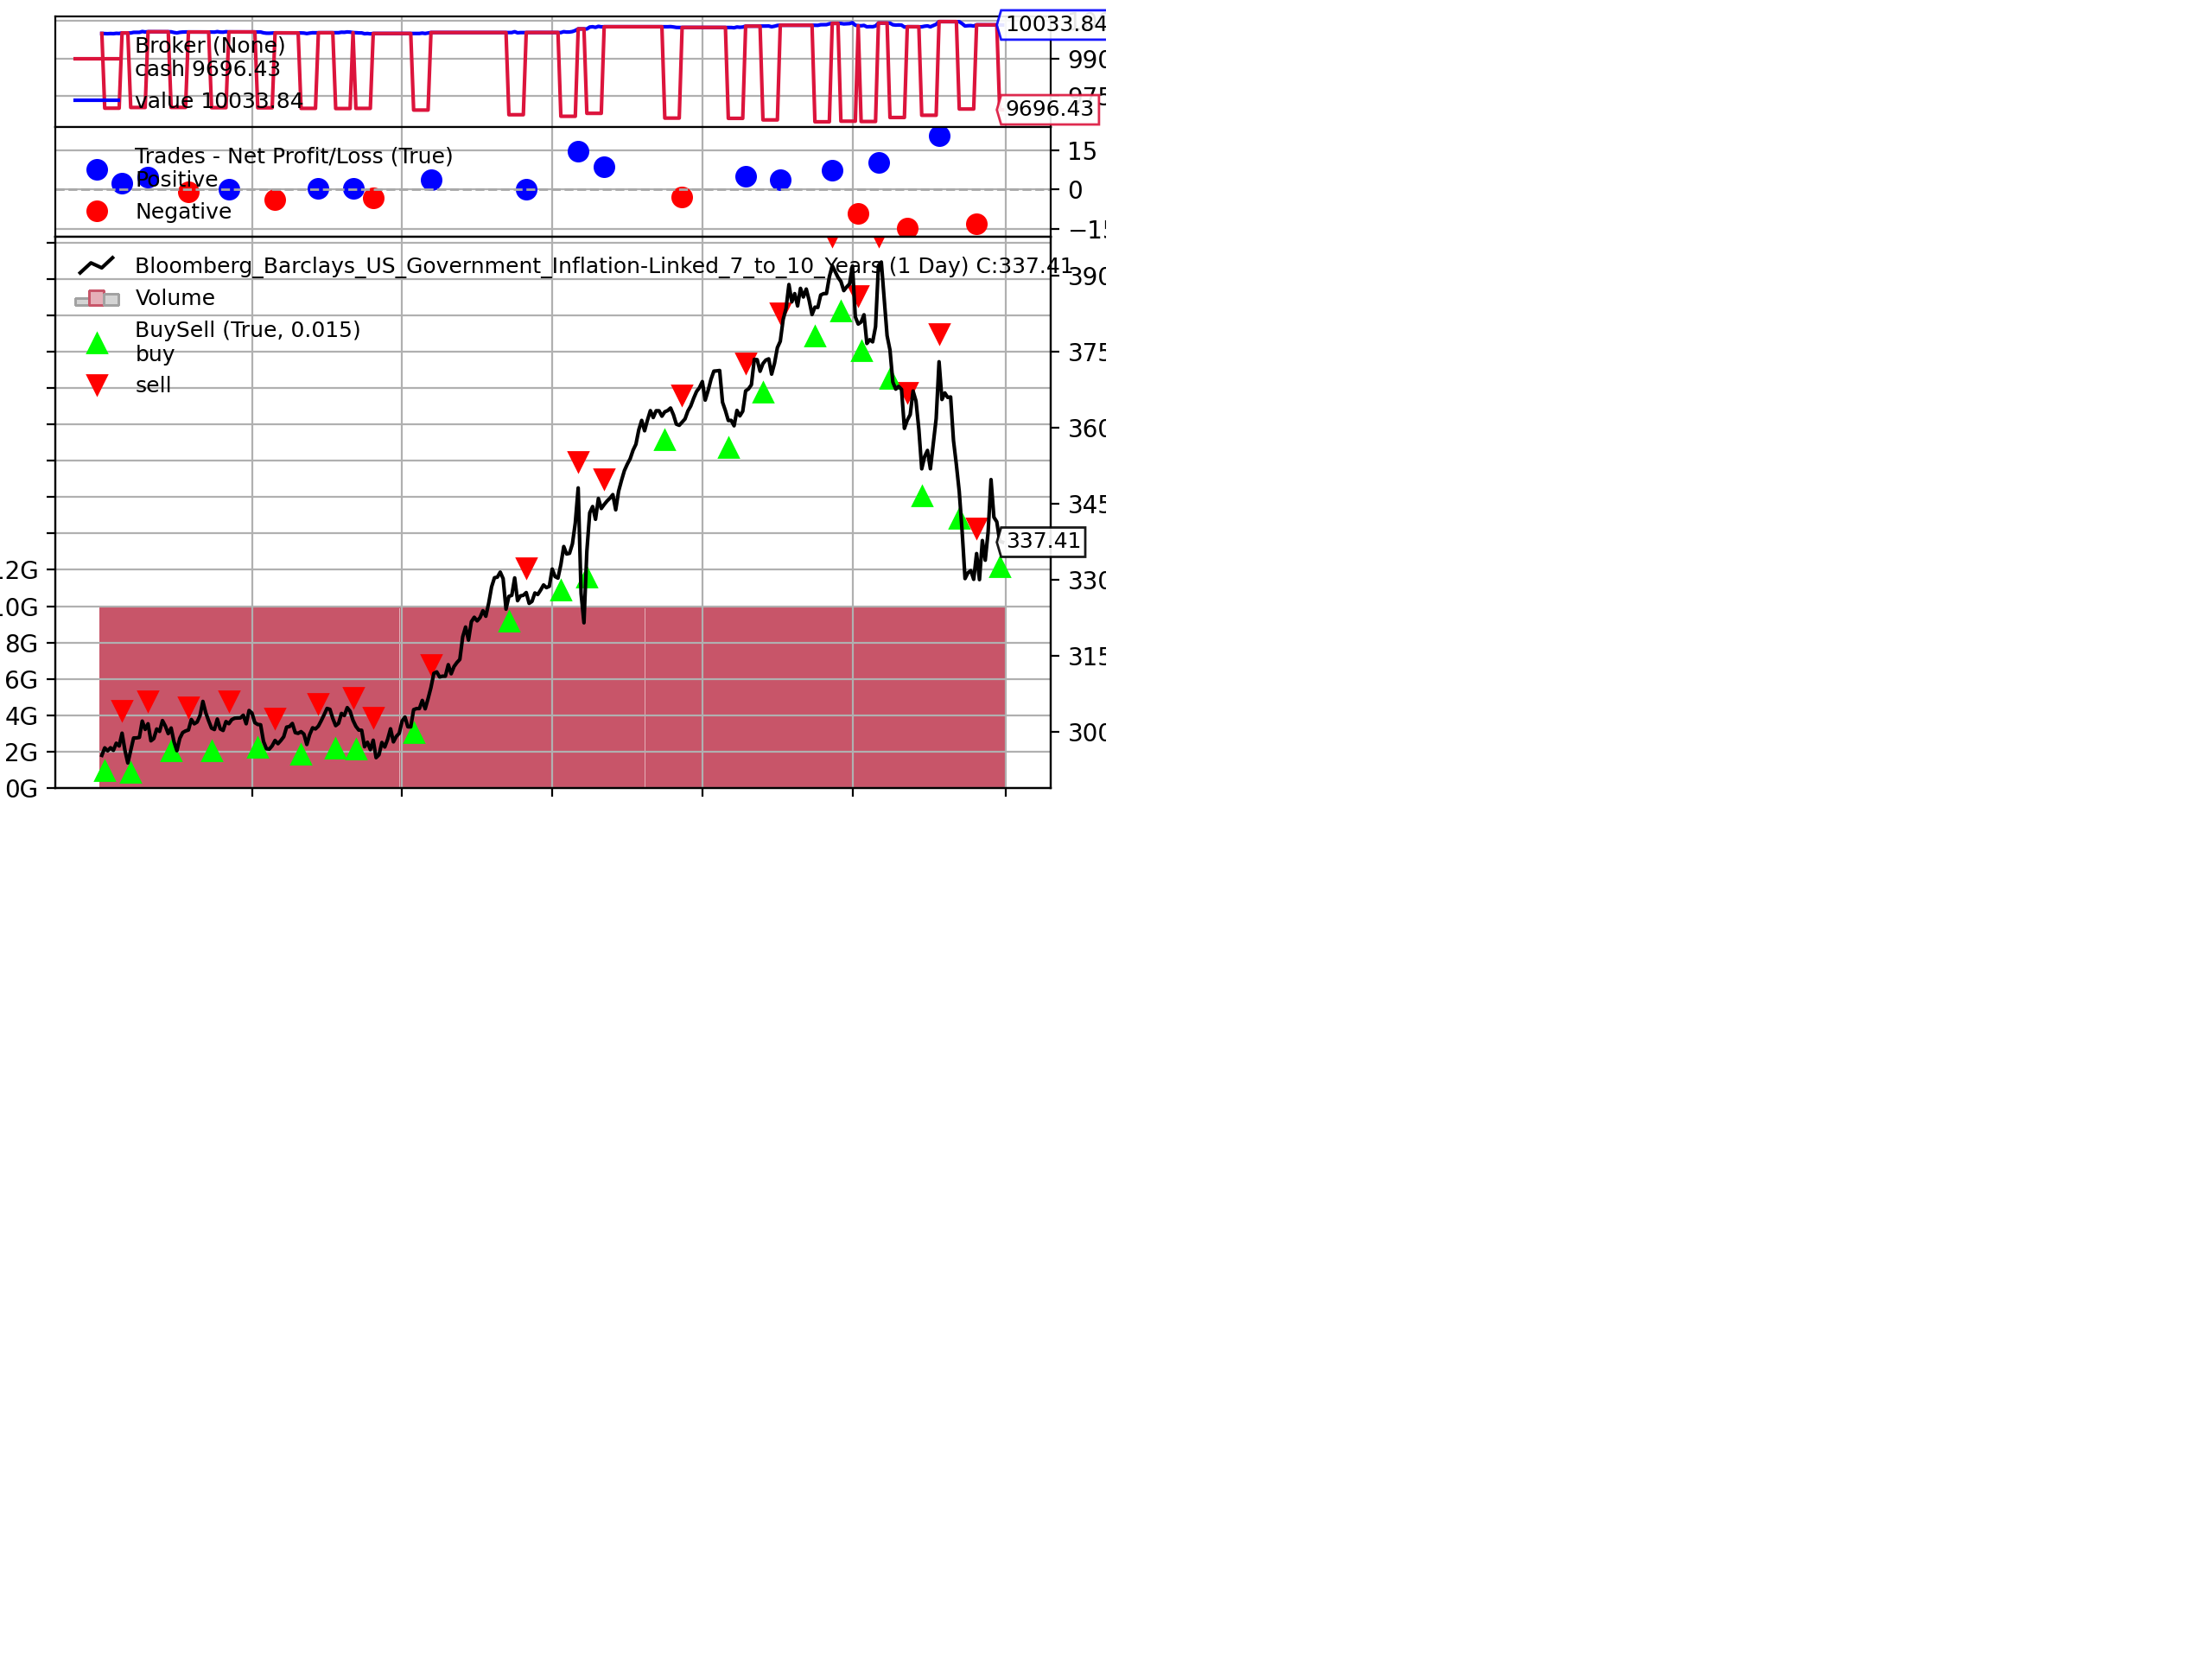

[[<Figure size 640x480 with 4 Axes>]]

In [8]:
cerebro.plot()

In [23]:
data1()